1. Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import matplotlib.pyplot as plt

2. Setup configurations

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

3. Paths

In [3]:
DATA_DIR = Path("../data/processed")
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

4. Load Dataset(s)

In [4]:
TABLE_NAME = "model_strict.csv"   # or "model_combined.csv"
df = pd.read_csv(DATA_DIR / TABLE_NAME)

5. Basic info

In [5]:
print(TABLE_NAME, df.shape)
df.head(3)

model_strict.csv (3067, 37)


,imdb_score,imdb_votes,imdb_votes_log1p,runtime,duration_minutes,release_year,desc_len,num_genres,is_show,is_classic,...,ctry_India,ctry_Japan,ctry_Nigeria,ctry_Other,ctry_Philippines,ctry_South Korea,ctry_Spain,ctry_United Kingdom,ctry_United States,ctry_Unknown
0,8.2,530877.0,13.182288,91,92,1975,415,3,0,1,...,False,False,False,False,False,False,False,True,False,False
1,7.8,94121.0,11.452347,170,173,1964,121,2,0,1,...,False,False,False,False,False,False,False,False,True,False
2,5.8,69053.0,11.142644,104,105,1980,347,2,0,1,...,False,False,False,False,False,False,False,False,True,False


6. Define target, features, split 70/15/15

In [6]:
# 1) Target & features
TARGET = "imdb_score"

drop_if_exists = {"title","id","imdb_id","description","is_high"}  # classification label not used here
feature_df = df.drop(columns=[c for c in drop_if_exists if c in df.columns])

X = feature_df.drop(columns=[TARGET])
y = feature_df[TARGET].astype(float)

# identify columns
numeric_cols = X.select_dtypes(include=["int64","float64","Int64","Float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object","string","category","bool","boolean","UInt8","Int8"]).columns.tolist()

# prefer duration_minutes over runtime if both exist
if "duration_minutes" in numeric_cols and "runtime" in numeric_cols:
    X = X.drop(columns=["runtime"])
    numeric_cols.remove("runtime")

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

# 70/15/15 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE)

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

Numeric: ['imdb_votes', 'imdb_votes_log1p', 'duration_minutes', 'release_year', 'desc_len', 'num_genres', 'is_show', 'is_classic']
Categorical: ['type', 'age_G', 'age_Other', 'age_PG', 'age_PG-13', 'age_R', 'age_TV-14', 'age_TV-G', 'age_TV-MA', 'age_TV-PG', 'age_TV-Y', 'age_TV-Y7', 'age_Unknown', 'ctry_Canada', 'ctry_France', 'ctry_India', 'ctry_Japan', 'ctry_Nigeria', 'ctry_Other', 'ctry_Philippines', 'ctry_South Korea', 'ctry_Spain', 'ctry_United Kingdom', 'ctry_United States', 'ctry_Unknown']
Train: (2146, 33) Valid: (460, 33) Test: (461, 33)


7. Preprocess & Baseline RandomForest

In [7]:
# 2) Preprocessing (same pattern as notebook 4)
num_tf = Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True))])
cat_tf = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocess = ColumnTransformer([
    ("num", num_tf, numeric_cols),
    ("cat", cat_tf, categorical_cols),
])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Baseline RF
rf_base = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1,
        max_depth=None, min_samples_leaf=1
    ))
])

rf_base.fit(X_train, y_train)
pred_va = rf_base.predict(X_valid)

print("Baseline RF — Valid:",
      f"MAE={mean_absolute_error(y_valid, pred_va):.3f}",
      f"RMSE={rmse(y_valid, pred_va):.3f}",
      f"R²={r2_score(y_valid, pred_va):.3f}")

Baseline RF — Valid: MAE=0.737 RMSE=0.984 R²=0.231


8. Hyperparameter search (RandomizedSearchCV)

In [8]:
# 3) Randomized search space for RF
param_dist = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [None, 10, 20, 30, 50],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.5, 0.7, 1.0]
}

rf_tune = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

search = RandomizedSearchCV(
    rf_tune,
    param_distributions=param_dist,
    n_iter=25,  # keep modest; you can increase later
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
best_rf = search.best_estimator_

pred_va = best_rf.predict(X_valid)
print("Tuned RF — Valid:",
      f"MAE={mean_absolute_error(y_valid, pred_va):.3f}",
      f"RMSE={rmse(y_valid, pred_va):.3f}",
      f"R²={r2_score(y_valid, pred_va):.3f}")
print("\nBest params:", search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Tuned RF — Valid: MAE=0.731 RMSE=0.977 R²=0.241

Best params: {'model__n_estimators': 800, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 0.5, 'model__max_depth': 50}


9. Retrain on Train+Valid, evaluate on Test

In [9]:
# 4) Retrain on Train+Valid
X_trv = pd.concat([X_train, X_valid], axis=0)
y_trv = pd.concat([y_train, y_valid], axis=0)

best_rf.fit(X_trv, y_trv)
pred_test = best_rf.predict(X_test)

print("\nFinal Test — Tuned RF:",
      f"MAE={mean_absolute_error(y_test, pred_test):.3f}",
      f"RMSE={rmse(y_test, pred_test):.3f}",
      f"R²={r2_score(y_test, pred_test):.3f}")


Final Test — Tuned RF: MAE=0.750 RMSE=0.975 R²=0.260


10. Permutation Importance (on validation or test)

,feature,perm_importance_mean,perm_importance_std
2,num__duration_minutes,0.180136,0.010001
1,num__imdb_votes_log1p,0.176281,0.014241
0,num__imdb_votes,0.168355,0.013615
3,num__release_year,0.152616,0.011576
4,num__desc_len,0.105833,0.008362
5,num__num_genres,0.077310,0.009243
9,cat__type_SHOW,0.059987,0.006683
6,num__is_show,0.051287,0.005928
8,cat__type_MOVIE,0.046577,0.005654
32,cat__age_Unknown_False,0.014898,0.001699


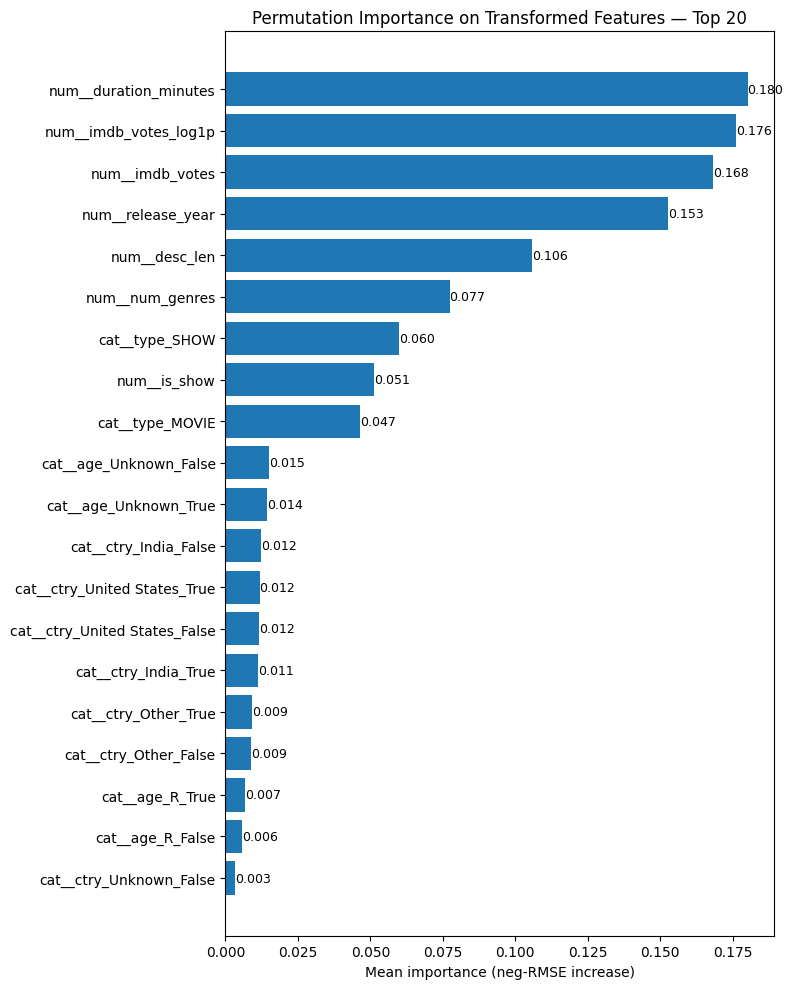

In [10]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

prep   = best_rf.named_steps["prep"]
model  = best_rf.named_steps["model"]

# Transform sets using the fitted preprocessor
Xv_t   = prep.transform(X_valid)   # numpy array
fv     = prep.get_feature_names_out()

# Run permutation on the MODEL ONLY (since Xv_t is already transformed)
perm_t = permutation_importance(
    model,
    Xv_t, y_valid,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="neg_root_mean_squared_error"
)

imp_df_t = pd.DataFrame({
    "feature": fv,
    "perm_importance_mean": perm_t.importances_mean,
    "perm_importance_std":  perm_t.importances_std
}).sort_values("perm_importance_mean", ascending=False)

display(imp_df_t.head(30))

# Plot Top-20 transformed features
top = imp_df_t.head(20).iloc[::-1]
plt.figure(figsize=(8, 10))
plt.barh(top["feature"], top["perm_importance_mean"])
for i, v in enumerate(top["perm_importance_mean"]):
    plt.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=9)
plt.title("Permutation Importance on Transformed Features — Top 20")
plt.xlabel("Mean importance (neg-RMSE increase)")
plt.tight_layout()
plt.show()

### PDP & ALE for top features, then save tuned pipeline

1. Import libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

2. Pull out preprocessor & model, and transform validation set

In [12]:
# 0) Pull out preprocessor & model, and transform validation set
prep   = best_rf.named_steps["prep"]     # ColumnTransformer
model  = best_rf.named_steps["model"]    # RandomForestRegressor (tuned)

Xv_t   = prep.transform(X_valid)         # transformed matrix
# feature names after preprocessing (will look like "num__...", "cat__...")
feat_names = prep.get_feature_names_out()
Xv_df = pd.DataFrame(Xv_t, columns=feat_names)

3. Choose top features from your permutation-importance results (imp_df_t)

In [13]:
#    Keep only features that exist in feat_names (defensive)
top_k = 6
top_feat_names = [f for f in imp_df_t.sort_values("perm_importance_mean", ascending=False)["feature"].tolist()
                  if f in feat_names][:top_k]

# For PDP we need indices (since model was fit on the transformed array)
top_feat_idx = [list(feat_names).index(f) for f in top_feat_names]

4. PARTIAL DEPENDENCE PLOTS (PDP)

/Users/antoniocasals/opt/anaconda3/envs/netflix-imdb/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/antoniocasals/opt/anaconda3/envs/netflix-imdb/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/antonio

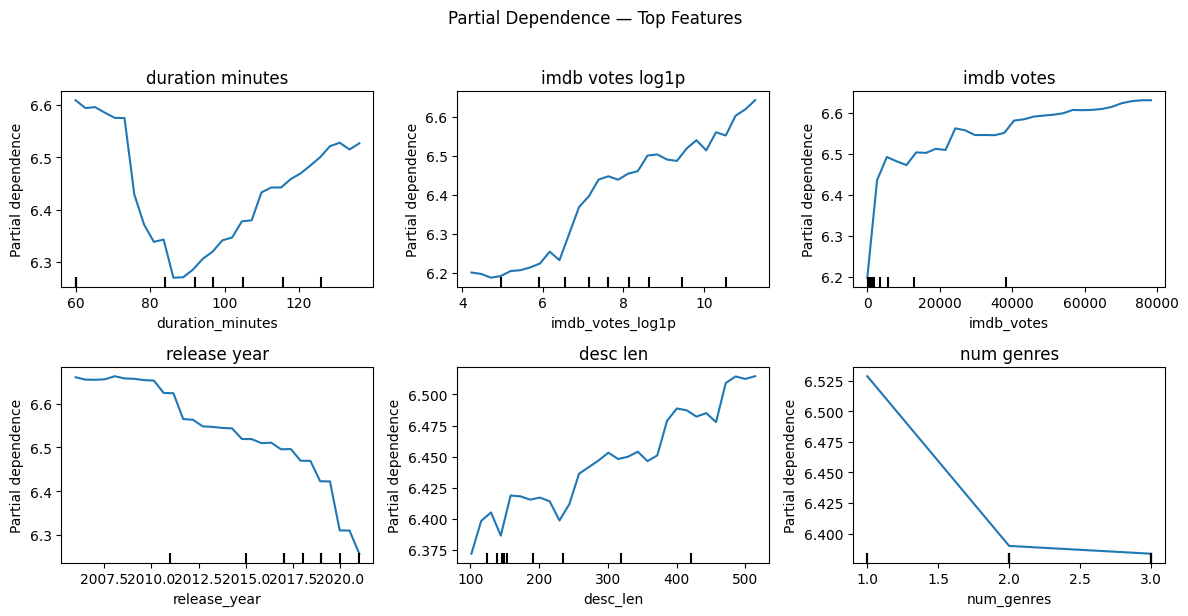

In [14]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

numeric_targets = [
    ("duration_minutes", "duration minutes"),
    ("imdb_votes_log1p", "imdb votes log1p"),
    ("imdb_votes", "imdb votes"),
    ("release_year", "release year"),
    ("desc_len", "desc len"),
    ("num_genres", "num genres"),
]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.ravel()

for ax, (feat, title) in zip(axes, numeric_targets):
    PartialDependenceDisplay.from_estimator(
        best_rf, X_valid, features=[feat],
        kind="average", grid_resolution=30,
        feature_names=X_valid.columns, ax=ax
    )
    ax.set_title(title)

plt.suptitle("Partial Dependence — Top Features", y=1.02)
plt.tight_layout()
plt.show()

5. Accumulated local effects (ALE)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_ale_1d(model_pipeline, X_df: pd.DataFrame, feature: str, n_bins: int = 20):
    """
    1D ALE for a numeric feature using a fitted scikit-learn Pipeline.
    Robust to non-default DataFrame indices (uses reset + iloc).
    """
    if feature not in X_df.columns:
        raise ValueError(f"Feature '{feature}' not in dataframe columns.")

    # Work on a copy with positional index 0..N-1
    X = X_df.copy().reset_index(drop=True)

    # numeric array of the feature
    x = pd.to_numeric(X[feature], errors="coerce").to_numpy()

    # quantile bin edges (unique & strictly increasing)
    q = np.linspace(0, 1, n_bins + 1)
    edges = np.unique(np.nanquantile(x, q))
    if len(edges) < 3:
        xmin, xmax = np.nanmin(x), np.nanmax(x)
        edges = np.linspace(xmin, xmax, n_bins + 1)

    nI = len(edges) - 1
    centers = 0.5 * (edges[:-1] + edges[1:])
    local = np.zeros(nI)
    counts = np.zeros(nI, dtype=int)

    # copies to mutate per-bin
    X_low  = X.copy()
    X_high = X.copy()

    col_pos = X.columns.get_loc(feature)

    for k in range(nI):
        lo, hi = edges[k], edges[k + 1]
        if k < nI - 1:
            in_bin = (x >= lo) & (x < hi)
        else:
            in_bin = (x >= lo) & (x <= hi)

        idx = np.where(in_bin)[0]
        counts[k] = idx.size
        if idx.size == 0:
            local[k] = 0.0
            continue

        # set feature values at positions 'idx' to bin edges (positional iloc!)
        X_low.iloc[idx,  col_pos] = lo
        X_high.iloc[idx, col_pos] = hi

        # predict and slice predictions by position
        pred_low  = model_pipeline.predict(X_low).astype(float)[idx]
        pred_high = model_pipeline.predict(X_high).astype(float)[idx]

        local[k] = np.mean(pred_high - pred_low)

        # restore original values for next bin
        X_low.iloc[idx,  col_pos] = x[idx]
        X_high.iloc[idx, col_pos] = x[idx]

    # accumulate and center to zero mean (weighted by bin frequency)
    ale = np.cumsum(local)
    weights = counts / counts.sum() if counts.sum() else np.ones_like(counts) / len(counts)
    ale_centered = ale - np.sum(ale * weights)

    return centers, ale_centered, counts


def plot_ale_grid(model_pipeline, X_df, features, n_bins=20, figsize=(12, 6)):
    n = len(features)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.ravel()

    for i, feat in enumerate(features):
        centers, ale, counts = compute_ale_1d(model_pipeline, X_df, feat, n_bins=n_bins)
        ax = axes[i]
        ax.plot(centers, ale)
        ax.set_title(feat.replace("_", " "))
        ax.set_xlabel(feat)
        ax.set_ylabel("ALE")

        # Optional bin “rug” scaled to 5% of ALE range
        ymin, ymax = np.min(ale), np.max(ale)
        if np.any(counts):
            scale = (ymax - ymin) * 0.05 if ymax > ymin else 0.05
            ax.vlines(centers, ymin, ymin + (counts / counts.max()) * scale, lw=1, alpha=0.3)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle("Accumulated Local Effects (ALE) — 1D", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

/var/folders/3y/3t9y2w7n5fb6lt73nw9p5zrc0000gn/T/ipykernel_13607/2900596287.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '70.65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_high.iloc[idx, col_pos] = hi
/var/folders/3y/3t9y2w7n5fb6lt73nw9p5zrc0000gn/T/ipykernel_13607/2900596287.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '70.65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_low.iloc[idx,  col_pos] = lo
/var/folders/3y/3t9y2w7n5fb6lt73nw9p5zrc0000gn/T/ipykernel_13607/2900596287.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '103.80000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X

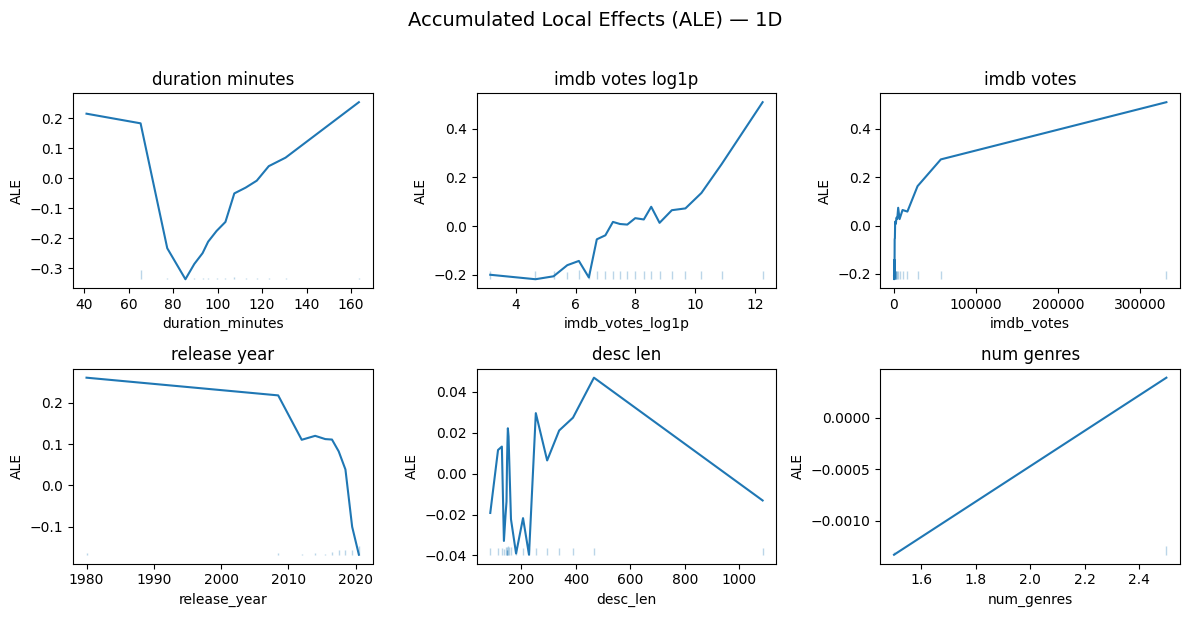

In [16]:
top_numeric = ["duration_minutes", "imdb_votes_log1p", "imdb_votes",
               "release_year", "desc_len", "num_genres"]

plot_ale_grid(best_rf, X_valid, top_numeric, n_bins=20, figsize=(12, 6))

6. SAVE THE TUNED PIPELINE (preprocess + model)

In [17]:
import joblib, os
os.makedirs("../models", exist_ok=True)
pipe_path = "../models/tuned_randomforest_pipeline.joblib"
joblib.dump(best_rf, pipe_path)
print(f"[ok] Saved tuned pipeline → {pipe_path}")

[ok] Saved tuned pipeline → ../models/tuned_randomforest_pipeline.joblib


7. Key Takeaways (Permutation Importance + PDP)

Strongest drivers:

	1.	duration_minutes — IMDb score dips for movies/shows around ~80 minutes, then gradually rises again for longer runtimes (>100 mins). This could reflect lower production quality in very short content, with higher scores linked to more substantial features or series episodes.
	2.	imdb_votes_log1p & imdb_votes — Both show a strong positive relationship: more votes (especially in log scale) generally correlate with higher ratings. This likely reflects popularity and broader appeal.
	3.	release_year — Slight decline in ratings for more recent releases after ~2010, possibly due to harsher viewer expectations or changes in Netflix’s content mix.

Moderate impact:

    4. desc_len — Longer descriptions are associated with slightly higher scores, perhaps indicating richer content marketing or more detailed storylines.
    5. num_genres — Content with more than one genre tends to have lower average ratings; the drop flattens beyond 2 genres. Could signal genre dilution.

7. Check to see the effect of Movie and Show on the predicted score

,category,mean_pred,delta_vs_global
0,MOVIE,6.278006,-0.140097
1,SHOW,6.778074,0.359971


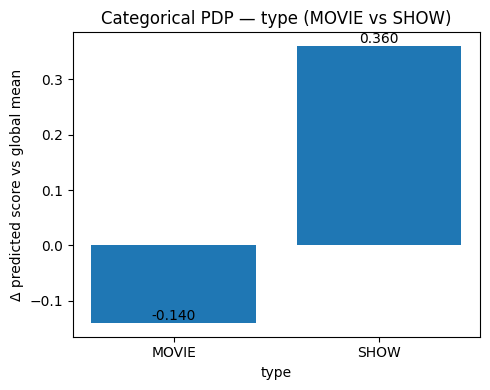

Estimated effect SHOW − MOVIE ≈ +0.500 IMDb points (avg prediction).


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def categorical_pdp(pipe, X, feature, categories=None, baseline="global"):
    """
    For each category value, set X[feature] to that value, predict with the pipeline,
    and take the mean prediction. Optionally show deltas vs a baseline.

    baseline: "global" (mean pred on original X) or None (show raw means)
    """
    if categories is None:
        categories = pd.Index(X[feature].dropna().unique()).tolist()

    base = None
    if baseline == "global":
        base = pipe.predict(X).mean()

    rows = []
    for cat in categories:
        Xc = X.copy()
        Xc[feature] = cat
        mean_pred = pipe.predict(Xc).mean()
        rows.append({"category": cat, "mean_pred": mean_pred})

    out = pd.DataFrame(rows)
    if base is not None:
        out["delta_vs_global"] = out["mean_pred"] - base
    return out

# --- run for 'type' ---
cats = ["MOVIE", "SHOW"]  # ensure stable order
pdp_type = categorical_pdp(best_rf, X_valid, feature="type", categories=cats, baseline="global")
display(pdp_type)

# --- plot ---
vals = pdp_type["delta_vs_global"] if "delta_vs_global" in pdp_type else pdp_type["mean_pred"]
ylabel = "Δ predicted score vs global mean" if "delta_vs_global" in pdp_type else "Mean predicted score"

plt.figure(figsize=(5,4))
bars = plt.bar(pdp_type["category"], vals)
for b,v in zip(bars, vals):
    plt.text(b.get_x() + b.get_width()/2, b.get_height(),
             f"{v:.3f}", ha="center", va="bottom", fontsize=10)
plt.title("Categorical PDP — type (MOVIE vs SHOW)")
plt.ylabel(ylabel)
plt.xlabel("type")
plt.tight_layout()
plt.show()

# quick textual summary
if "delta_vs_global" in pdp_type:
    diff = float(pdp_type.loc[pdp_type["category"]=="SHOW", "delta_vs_global"].values[0] -
                 pdp_type.loc[pdp_type["category"]=="MOVIE", "delta_vs_global"].values[0])
    print(f"Estimated effect SHOW − MOVIE ≈ {diff:+.3f} IMDb points (avg prediction).")

8. Quick Robustness checks

SHOW − MOVIE: 0.500  (95% CI: [0.470, 0.530])


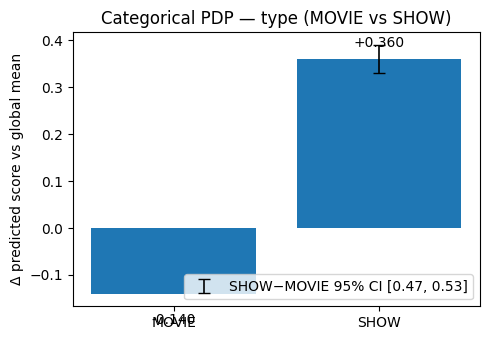

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

# 1) Base categorical PDP (reuse your best_rf, X_valid)
Xv = X_valid.copy()
global_mean = best_rf.predict(Xv).mean()

def flip_and_pred(df, cat_value):
    df2 = df.copy()
    df2["type"] = cat_value
    return best_rf.predict(df2)

pred_movie = flip_and_pred(Xv, "MOVIE")
pred_show  = flip_and_pred(Xv, "SHOW")

mean_movie = pred_movie.mean()
mean_show  = pred_show.mean()
delta_movie = mean_movie - global_mean
delta_show  = mean_show  - global_mean
diff = mean_show - mean_movie

# 2) Bootstrap CI for difference (SHOW − MOVIE)
B = 1000
n = len(Xv)
boot_diffs = np.empty(B)
for b in range(B):
    idx = rng.integers(0, n, n)
    bm = flip_and_pred(Xv.iloc[idx], "MOVIE").mean()
    bs = flip_and_pred(Xv.iloc[idx], "SHOW").mean()
    boot_diffs[b] = bs - bm

lo, hi = np.percentile(boot_diffs, [2.5, 97.5])

print(f"SHOW − MOVIE: {diff:.3f}  (95% CI: [{lo:.3f}, {hi:.3f}])")

# 3) Plot deltas with error bar for the difference
cats = ["MOVIE", "SHOW"]
deltas = [delta_movie, delta_show]

plt.figure(figsize=(5,3.5))
bars = plt.bar(cats, deltas)
for i, v in enumerate(deltas):
    plt.text(i, v + (0.02 if v>=0 else -0.04), f"{v:+.3f}", ha="center", va="bottom" if v>=0 else "top")
plt.title("Categorical PDP — type (MOVIE vs SHOW)")
plt.ylabel("Δ predicted score vs global mean")

# Add error bar for the SHOW−MOVIE diff above the SHOW bar
plt.errorbar(
    x=[1], y=[delta_show],
    yerr=[[diff - lo], [hi - diff]],
    fmt='none', ecolor='black', capsize=4, lw=1.2, label=f"SHOW−MOVIE 95% CI [{lo:.2f}, {hi:.2f}]"
)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

The bootstrap confidence interval for SHOW − MOVIE is tight (±0.03) and fully above zero, which supports the idea that, according to the model, shows are predicted to score about half a point higher than movies, on average.

### Short Findings

Goal: predict IMDb score; understand what drives predictions.

What we learned:

	•	Most influential features (perm. importance):
		duration_minutes, imdb_votes_log1p (and raw votes), release_year, then desc_len and num_genres.
	
	•	Shape of effects (PDP / ALE):
		• Scores increase with votes (diminishing returns in log space).
		• Duration dips around ~80–90 minutes, then rises (non-monotonic).
		• Newer releases trend slightly down after ~2015 (in our sample).
		• Longer descriptions correlate weakly up; more genres trends slightly down.
	
	•	Type effect (MOVIE vs SHOW): categorical PDP with bootstrap CI estimates SHOW − MOVIE ≈ +0.50 IMDb points (95% CI ≈ [+0.47, +0.53]). This is an association captured by the model, not causal.
	•	Model: Tuned RandomForest achieved ~RMSE ≈ 0.98 on the held-out test set (R² ≈ 0.25). Ridge/Linear trail behind.

Saved artifacts

	•	Tuned regression pipeline: models/tuned_randomforest_pipeline.joblib
	•	Model tables: data/processed/model_strict.csv and .parquet